In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit,train_test_split
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from itertools import combinations
import statsmodels.api as sm
import statsmodels.tools as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def import_data(experimental_file, response_file, response, random_state1):
    'imports data'
    'experimental_file = experimental design csv filename i.e experimental.csv'
    'response_file = results csv filename i.e Response.csv'
    'response = reponse name: i.e rheomix final deg time min or rheomix stability time min'
    
    experimental_df = pd.read_csv(experimental_file)
    response_df = pd.read_csv(response_file)
    
    X = experimental_df[experimental_df.columns.values.tolist()[1:]].values
    y = response_df[response].values
    max1 = max(y)
    min1 = min(y)

    y_norm = [2*((i-min1)/(max1-min1)) - 1 for i in y]

    linear_terms = experimental_df.columns.values.tolist()[1:]
    x_train, x_test, y_train, y_test = train_test_split(X, y_norm, test_size=5/46, random_state= random_state1)
    
    return x_train, x_test, y_train, y_test, linear_terms, experimental_df, response_df
    

In [3]:
def X_gen(model, X_linear):

    for i, j in enumerate(model):
        
        if i == 0 and len(j) == 2: 
            X_new = X_linear[:, model[0][1]]
        
        else:
            
            if len(j) == 2:
                add = X_linear[:, j[1]]

            if len(j) == 3:
                add = X_linear[:, j[1]]*X_linear[:, j[2]]

            X_new2 = np.column_stack((X_new, add))
            X_new = X_new2

    
    return X_new

In [4]:
start = time.time()


# linear_terms = experimental_df.columns.values.tolist()[1:]



def fit_model(experimental_file, response_file, response, random_state1):
    

    total_subset = []

    x_train, x_test, y_train, y_test, linear_terms, experimental_df, response_df = import_data(experimental_file, response_file, response, random_state1)
    y = y_train
    X_linear = x_train
    y1 = np.array(y)
    lin_terms = []
    AIC_prev = 1000
    AICc_prev = 1000
    BIC_prev = 1000
    av_score_prev = 0


    for i in range(len(linear_terms)):
        term = linear_terms[i]
        key = i
        lin_terms.append([term, i])

    cnt = 0
    for i in range(len(lin_terms)):
        for j in combinations(lin_terms, i+1):
            linear_terms = list(j)


            model = [a for a in linear_terms]
            cnt+=1

            X = X_gen(model, X_linear)

            model_fit = sm.OLS(y, X)
            results = model_fit.fit()
            AICc_cur = st.eval_measures.aicc(results.llf, results.nobs, results.df_model)
            AIC_cur = results.aic
            BIC_cur = results.bic
            
            if AICc_cur < 40:
                if len(model) == 1:

                    X1 = X.reshape(len(X), 1)
                    model_obj = LinearRegression(fit_intercept=False)
                    my_cv = ShuffleSplit(n_splits=10, test_size=0.333, random_state=0)

                    score = cross_val_score(model_obj, X1, y1, cv=my_cv)
                    av_score = sum(score)/len(score)

                else:

                    model_obj = LinearRegression(fit_intercept=False)
                    my_cv = ShuffleSplit(n_splits=10, test_size=0.333, random_state=0)

                    score = cross_val_score(model_obj, X, y1, cv=my_cv)
                    av_score = sum(score)/len(score)

            else:
                av_score = -1
            
            if AIC_cur < AIC_prev:

                AIC_prev = AIC_cur
                final_model_AIC = [model, results, AIC_cur]
                
            if AICc_cur < AICc_prev:

                AICc_prev = AICc_cur
                final_model_AICc = [model, results, AICc_cur]
                
            if BIC_cur < BIC_prev:

                BIC_prev = BIC_cur
                final_model_BIC = [model, results, BIC_cur]
                
            if av_score_prev < av_score:
                
                av_score_prev= av_score
                final_model_kfold = [model, results, av_score]
    



            poss_terms = []
            for i in range(len(linear_terms)):
                for j in range(len(linear_terms)): 
                    if i < j:
                        poss_terms.append([linear_terms[i][0] + '*' + linear_terms[j][0],  linear_terms[i][1], linear_terms[j][1]])



            for m in range(1, len(poss_terms) + 1):
                for k in combinations(poss_terms, m):

                    model = [a for a in linear_terms]
                    for i in range(m):
                        model.append(k[i])

                    cnt +=1
                    
                    if len(model) < 12:
                        
                        X = X_gen(model, X_linear)

                        model_fit = sm.OLS(y, X)
                        results = model_fit.fit()
                        AICc_cur = st.eval_measures.aicc(results.llf, results.nobs, results.df_model)
                        AIC_cur = results.aic
                        BIC_cur = results.bic

                        if AICc_cur < 40:
                            
                            model_obj = LinearRegression(fit_intercept=False)
                            my_cv = ShuffleSplit(n_splits=10, test_size=0.333, random_state=0)

                            score = cross_val_score(model_obj, X, y1, cv=my_cv)
                            av_score = sum(score)/len(score)

                        else:
                            av_score = -1



                        if AIC_cur < AIC_prev:

                            AIC_prev = AIC_cur
                            final_model_AIC = [model, results, AIC_cur]

                        if AICc_cur < AICc_prev:

                            AICc_prev = AICc_cur
                            final_model_AICc = [model, results, AICc_cur]

                        if BIC_cur < BIC_prev:

                            BIC_prev = BIC_cur
                            final_model_BIC = [model, results, BIC_cur]

                        if av_score_prev < av_score:
                            
                            av_score_prev= av_score
                            final_model_kfold = [model, results, av_score]
                            

    #AIC:
    model = final_model_AIC[0]
    X = X_gen(model, X_linear)
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X, y_train)
    X_test = X_gen(model, x_test)
    y_pred = regr.predict(X_test)
    AIC_mse = mse(y_test, y_pred)
    final_model_AIC.append(AIC_mse)
    
    #AICc:
    model = final_model_AICc[0]
    X = X_gen(model, X_linear)
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X, y_train)
    X_test = X_gen(model, x_test)
    y_pred = regr.predict(X_test)
    AICc_mse = mse(y_test, y_pred)
    final_model_AICc.append(AICc_mse)
    
    #BIC:
    model = final_model_BIC[0]
    X = X_gen(model, X_linear)
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X, y_train)
    X_test = X_gen(model, x_test)
    y_pred = regr.predict(X_test)
    BIC_mse = mse(y_test, y_pred)
    final_model_BIC.append(BIC_mse)
    
    
    #kfold:
    model = final_model_kfold[0]
    X = X_gen(model, X_linear)
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X, y_train)
    X_test = X_gen(model, x_test)
    y_pred = regr.predict(X_test)
    kfold_mse = mse(y_test, y_pred)
    final_model_kfold.append(kfold_mse)
    
    
    
    
    return final_model_AIC, final_model_AICc, final_model_BIC, final_model_kfold


In [5]:
experimental_file = 'experimental.csv'
response_file = 'Response.csv'


test1 = 'rheomix final deg time min'
test2 = 'rheomix stability time min'
response = test1

AICc = []
BIC = []
kfold = []
for i in range(5):
    random_state1 = i
    final_model_AIC, final_model_AICc, final_model_BIC, final_model_kfold = fit_model(experimental_file, response_file, response, random_state1)
    AICc.append(final_model_AICc)
    BIC.append(final_model_BIC)
    kfold.append(final_model_kfold)


In [6]:
tests = []
for i in range(len(AICc)):
    a = [AICc[i][3], BIC[i][3], kfold[i][3]]   
    tests.append(a)

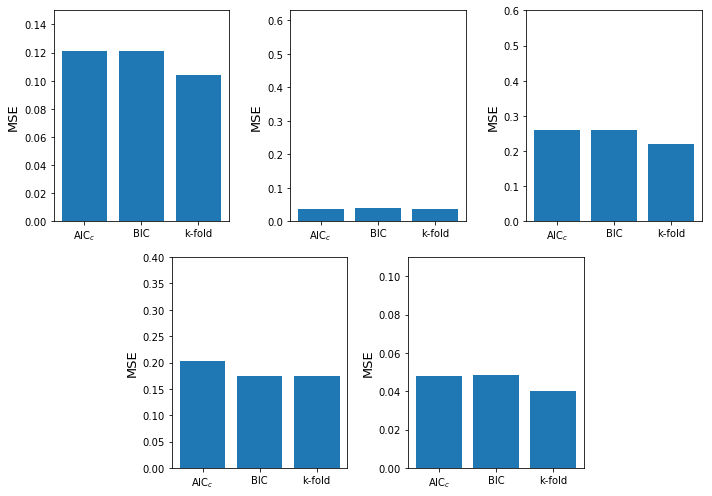

In [18]:
x_label = ['','AIC$_{c}$', 'BIC', 'k-fold']
x = [1,2,3]
fig, axs = plt.subplots(5, figsize=(10,7))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax1.bar(x, tests[0])
ax1.set_xticklabels(x_label)
ax1.set_ylim(top = 0.15)
ax1.set_ylabel('MSE', fontsize = 13)
ax2.bar(x, tests[1])
ax2.set_xticklabels(x_label)
ax2.set_ylim(top = 0.63)
ax2.set_ylabel('MSE', fontsize = 13)
ax3.bar(x, tests[2])
ax3.set_xticklabels(x_label)
ax3.set_ylim(top = 0.6)
ax3.set_ylabel('MSE', fontsize = 13)
ax4.bar(x, tests[3])
ax4.set_xticklabels(x_label)
ax4.set_ylim(top = 0.4)
ax4.set_ylabel('MSE', fontsize = 13)
ax5.bar(x, tests[4])
ax5.set_xticklabels(x_label)
ax5.set_ylim(top = 0.11)
ax5.set_ylabel('MSE', fontsize = 13)
fig.tight_layout()
fig.savefig('test_err_bar.png')

In [8]:
# df = pd.DataFrame(total_subset)
# df.to_csv("(K=10)_NoVIF_Total_model_subset_"  + response + ".csv")


In [9]:
# final_model, final_model[1].summary(), final_model_kfold, final_model_kfold[1].summary()

In [10]:
# plt.plot(CN_hist, AIC_hist, 'r*')
# plt.axis([0, 2000, 12, 20])
# plt.xlabel('CN')
# plt.ylabel('AIC')
# plt.show()

In [11]:
# plt.plot(VIF_max_hist, AIC_hist1, 'r*')
# plt.show()

In [12]:
# plt.scatter(CN_hist1, AIC_hist1, c = VIF_max_hist, vmin=0, vmax=50)
# # plt.axis([0, 1000, 12, 20])
# plt.xlabel('CN')
# plt.ylabel('AIC')
# plt.colorbar()
# # plt.set_label('VIF')
# plt.show()

In [13]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(CN_hist1,VIF_max_hist, AIC_hist1)
# plt.xlabel('CN')
# plt.ylabel('VIF')
# ax.set_zlabel('AIC')
# # plt.axis([0, 1000, 12, 18])
# # plt.colorbar()
# plt.show()

In [14]:
# len(model_subset)

In [15]:
# for i in model_subset:
#     if i[2] < 550 and i[2] > 450:
#         a = []
#         for j in i[0]:
#             a.append(j[0])
#         print('----model:', a, 'AIC', round(i[1], 3), 'CN:', round(i[2], 3), 'vif_max:', round(i[3], 3), 'R2:', round(i[4], 3), '----'
#              )
        

## 